# Analysis of local search behavior after reward in single-object forest
### For experiments with multiple conditions tested (not in single fly). First part of notebook to copare acorss flies within single condition (e.g. with or without LMs), second part to compare across conditions.
* Assumes use of FlyOver version 1.0.7 or higher (closed-loop optogenetic stimulation *with reset radius*)
* Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [58]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from scipy import stats as sts

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptoPulseTrialAnalysis

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot

In [59]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

## (1) Analysis of single condition
### Select rawData folder

In [60]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following {} log files:\n'.format(len(FODataFiles)))
for FOfile in FODataFiles:
    print(FOfile) 


 Analysing the following 4 log files:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_6-7d_180922154342.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_6-7d_180922163047.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f03_25h_7-8d_180925153957.txt
singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f04_26h_7-8d_180925160143.txt


In [61]:
dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')
    
rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')

Analysis directory already exists.
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [62]:
FODataFiles = FODataFiles[:]
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#my_indices = [2, 3, 4, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29]
#FODataFiles = itemgetter(*my_indices)(expDirs)

selectionTag = ''#'_min3visitsEachPre'  # chose small string, to specify dataset (e.g. top5 flies)

### Compose mutli-fly data into dataframe

In [63]:
# generate fly color map
numFlies = len(FODataFiles)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [64]:
genotype = dataDir.split(sep)[-3]
protocol = dataDir.split(sep)[-2]
print(genotype)
print(protocol)

hexGridSize = 240

24cmHex
visLM


In [65]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','protocol','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)
 
vTransTH = 2 #mm/s

# Run single trial analysis on each file in folder .....................................................
for fileToAnalyse in FODataFiles:
    print('\n Analysing the following log file:\n')
    print(fileToAnalyse)

    flyID = fileToAnalyse.split('_')[-4]
    starvation = fileToAnalyse.split('_')[-3]

    trial = FODataFiles.index(fileToAnalyse) + 1

    if rerunbasicanalysis == 'y':
        returnVal = singleVROptoPulseTrialAnalysis(expDir, fileToAnalyse, hexGridSize)
        print('Ran analysis, now loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    else:
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

    # Split into visible object trials and invisible object trials
    if 'train' in fileToAnalyse:
        trialtype = 'train'
        rZones = 'on'
    elif 'pre' in fileToAnalyse:
        trialtype = 'pre'
        rZones = 'off'
    else:
        trialtype = 'post'
        rZones = 'off'

    vTrans = np.copy(FODatLoad['transVelo'])
    moving = vTrans >= vTransTH

    FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
    FODatLoad_df.insert(0, 'flyID', flyID)
    FODatLoad_df.insert(1, 'trial', trial)
    FODatLoad_df.insert(2, 'trialtype', trialtype)
    FODatLoad_df.insert(3, 'reinforcement', rZones)
    FODatLoad_df.insert(4, 'protocol', protocol)
    FODatLoad_df.insert(5, 'moving', moving)

    FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_6-7d_180922154342.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_6-7d_180922163047.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f03_25h_7-8d_180925153957.txt
Loading saved *.npy file.

 Analysing the following log file:

singleObjectForest_visLM_1cm4cmCone_24cmHex_Gr64f-double-Gal4_x_10xChrR_f04_26h_7-8d_180925160143.txt
Loading saved *.npy file.


In [66]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df.head()

,flyID,trial,trialtype,reinforcement,protocol,moving,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.000000,0.000000,60.622,60.622,35.0,35.0,0.0
1,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.050004,0.000000,60.622,60.622,35.0,35.0,0.0
2,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.100008,0.000000,60.622,60.622,35.0,35.0,0.0
3,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.150012,0.000000,60.622,60.622,35.0,35.0,0.0
4,f01,1.0,post,off,visLM,0.0,-0.000004,0.0,0.200016,0.984213,60.622,60.622,35.0,35.0,0.0


In [67]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [68]:
%matplotlib inline

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [69]:
# Two object reinforcement test
trialName = ['search']
gridSize = hexGridSize

if 'noLM' in protocol:
    visibility = 'invisible'
    condCol = ['grey']
    evLevel = 90
elif 'onlyLM' in protocol:
    visibility = 'visible'
    condCol = ['cornflowerblue']
    evLevel = 0.5
else:
    visibility = 'visible'
    condCol = ['slateblue']
    evLevel = 90

fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'
LMcols = [coneColor]

LMnames = ['Cone']
nLMtypes = len(LMnames)

visitRad = 10
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

LMcoords = (0,0)

## Trajectory plots

In [70]:
# plot LM in "miniarena plot"
def plotSingleLMMiniArena(ax, gridSize, visibility):
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_xlim(-gridSize/2 - 5, gridSize/2 + 5)
    ax.set_ylim(-gridSize/2 - 5, gridSize/2 + 5)
    
    if visibility == 'invisible':
        ax.plot(0,0, marker='o', alpha=0.75, markeredgewidth=0.5, markerfacecolor='None', markeredgecolor='black')
    else:
        ax.plot(0,0, marker='o', alpha=0.75, markeredgewidth=0.5, markerfacecolor='black', markeredgecolor='black')

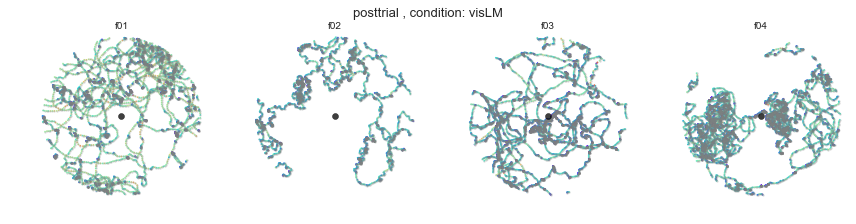

In [71]:
nrows = np.ceil(numFlies/4.0)
ptsOmit = 3 # scale how many time points are plotted

multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
figtitle = multiflyTracePlot.suptitle(trialtype + 'trial , condition: ' + protocol ,fontsize=13,y=1.02)
for fly in range(numFlies):
    multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)

    querystring = '(flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    

    selectPts = range(0,len(perFlyX),ptsOmit)
    multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
    multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                    vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
    
    plotSingleLMMiniArena(multiflyTracePlot_sbplt, gridSize, visibility)
    
    multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)


multiflyTracePlot.tight_layout()

multiflyTracePlot.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                          +'_traceVeloColored_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                          bbox_extra_artists=(figtitle,), bbox_inches='tight', transparent=True)

### Trajectory before and after first reward encounter

In [72]:
firsEncts = np.zeros((numFlies,2))
for fly in range(numFlies):
    querystring = '(flyID =="' + flyIDs[fly] +  '")'

    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    
    try:
        firstEncounter = int(np.where(ev > evLevel)[0][1])
        firsEncts[fly,:] = (firstEncounter, time[firstEncounter])
    except:
        firsEncts[fly,:] = (np.nan, np.nan)

Plot directory already exists


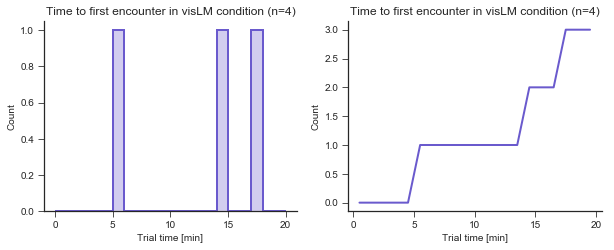

In [73]:
numBins=20
binRange = (0, 20)

hist, bin_edges = np.histogram(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange, density=False)

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2


encounterHistFig, axs = plt.subplots(1,2,figsize=(10,3.5))
axs[0].hist(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange,
            color=condCol[0], linewidth=2, histtype='stepfilled', alpha=0.3, label='{}'.format(protocol))
axs[0].hist(firsEncts[:,1][~np.isnan(firsEncts[:,1])]/60., bins=numBins, range=binRange,
            color=condCol[0], linewidth=2, histtype='step', label='{}'.format(protocol))
axs[1].plot(binEds,np.cumsum(hist*np.diff(bin_edges)), color=condCol[0], linewidth=2, label='{}'.format(protocol))

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlabel('Trial time [min]')
    ax.set_ylabel('Count')
    ax.set_title('Time to first encounter in {} condition (n={})'.format(protocol, numFlies))

try:
    mkdir(analysisDir + 'firstEncounter/')
except:
    print('Plot directory already exists')
encounterHistFig.savefig(analysisDir + 'firstEncounter/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                   +'_firstEncounterTimeHist_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

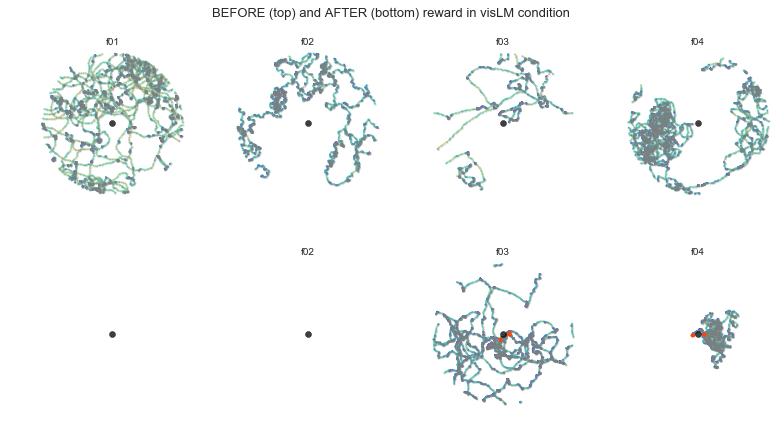

In [74]:
nrows = np.ceil((2*numFlies)/4.0)
ptsOmit = 3 # scale how many time points are plotted

allFlyTraceFig = plt.figure(figsize=(11,3*nrows))
figtitle = allFlyTraceFig.suptitle('BEFORE (top) and AFTER (bottom) reward in {} condition '.format(protocol),
                        fontsize=13,y=1.02)

for fly in range(numFlies):
    querystring = '(flyID =="' + flyIDs[fly] +  '")'

    perFlyX = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    perFlyY = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    perFlyEv = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    
    # Before
    ax = allFlyTraceFig.add_subplot(nrows,4,fly+1)
    if np.isnan(firsEncts[fly,0]):
        selectPts = range(0,len(perFlyX),ptsOmit)
    else:
        selectPts = range(0,int(firsEncts[fly,0]),ptsOmit)
        
    ax.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
    ax.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                    vmin=-1, vmax=35, edgecolor='none',alpha=0.9)

    plotSingleLMMiniArena(ax, gridSize, visibility)
    ax.set_title(flyIDs[fly],fontsize=10)
    
    # After
    ax = allFlyTraceFig.add_subplot(nrows,4,fly+1 + numFlies)
    if np.isnan(firsEncts[fly,0]):
        plotSingleLMMiniArena(ax, gridSize, visibility)
    else:
        selectPts = range(int(firsEncts[fly,0]), len(perFlyX), ptsOmit)
        
        ax.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        ax.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)

        ax.plot(perFlyX[perFlyEv>90],perFlyY[perFlyEv>90],'.',markersize=5,color='orangered',alpha=1)
        plotSingleLMMiniArena(ax, gridSize, visibility)
        ax.set_title(flyIDs[fly],fontsize=10)


allFlyTraceFig.tight_layout()

allFlyTraceFig.savefig(analysisDir +'tracePlotMA/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                          +'_traceBeforeAndAfter_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                          bbox_extra_artists=(figtitle,), bbox_inches='tight', transparent=True)

## Residency

### 2D (cartesian) residency in shifted space

Plot directory already exists


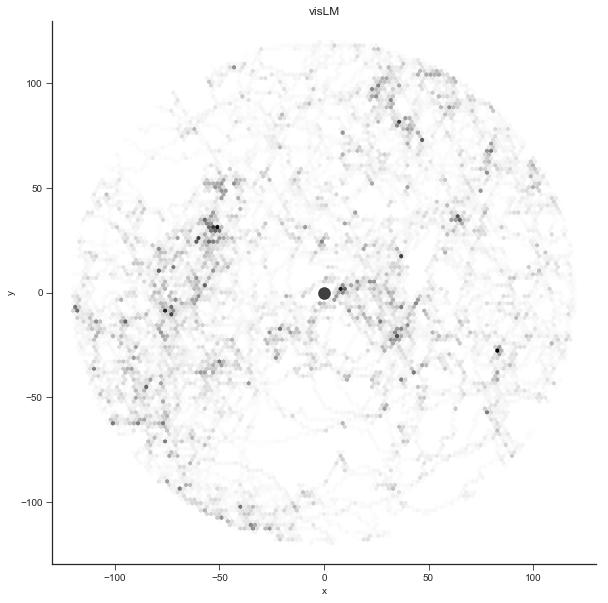

In [89]:
# plot parameter
numBins = hexGridSize/2

hexplotfig, ax = plt.subplots(1,1,figsize=(5*hexGridSize/120,5*hexGridSize/120))

querystring = '(moving > 0)'
xPosMA = np.asarray(FOAllFlies_df.query(querystring)['xPosInMiniarena']).squeeze()
yPosMA = np.asarray(FOAllFlies_df.query(querystring)['yPosInMiniarena']).squeeze()

ax.hexbin(xPosMA, yPosMA, gridsize=numBins, cmap='Greys',linewidths=0,vmin=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
if visibility == 'invisible':
    ax.plot(LMcoords[0], LMcoords[1], marker='o', markersize=12, alpha=0.75, markeredgewidth=0.5,
                    markerfacecolor='None', markeredgecolor='black')
else:
    ax.plot(LMcoords[0], LMcoords[1], marker='o', markersize=12, alpha=0.75, markeredgewidth=0.5,
                    markerfacecolor='black', markeredgecolor='black')
ax.set_title(protocol)
ax.set_xlim(-gridSize/2-10,gridSize/2+10)
ax.set_ylim(-gridSize/2-10,gridSize/2+10)
ax.set_aspect('equal')
myAxisTheme(ax)

try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

In [90]:
# Residency before and after reward

### 1D radial residency close around objects

In [91]:
resdf_keylist_short = ['flyID','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2LM', 'condition']

In [92]:
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for fly in range(len(flyIDs)):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()

    # compute distance to closest landmark for each type
    dist2LM = np.hypot((xtrial-LMcoords[0]),(ytrial-LMcoords[1]))
    tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
    tmpdf.insert(1,'dist2LM', dist2LM)
    tmpdf.insert(1,'condition', protocol)

    residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

In [93]:
movementFilter = 'moving > 0'
histRange = (5,hexGridSize/2)
numBins = 25
varStyle = 'iqr' #'std'
lineAlpha = 1

condLegend = [protocol]

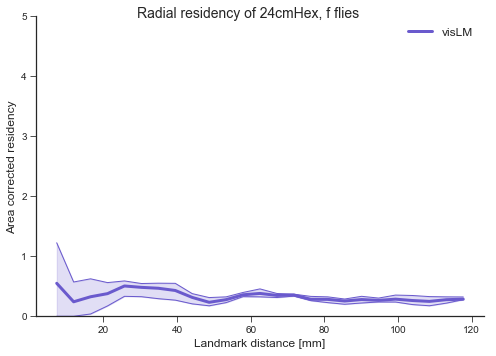

In [94]:
# linear residency around landmarks
radResFig, ax = plt.subplots(1,1,figsize=(7,5))
ax = oneDimResidencyWithVar_df(ax, residency_df, flyIDs, movementFilter, numBins, histRange, lineAlpha, 0, 
                               varStyle, 1, condCol, condLegend)
myAxisTheme(ax)
ax.set_ylim(0, 5)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol+'_radialResidencyVar_'
                   +varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

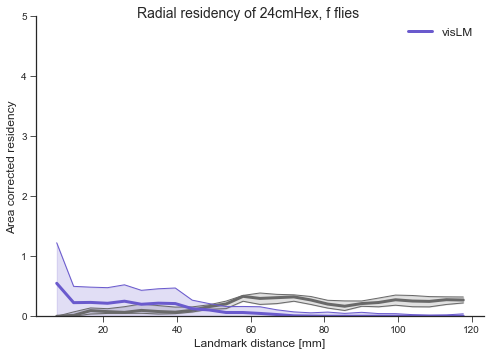

In [95]:
# linear residency around landmarks split into "BEFORE" and "AFTER" first reward encounter

radResFig, ax = plt.subplots(1,1,figsize=(7,5))
cols = [['dimgrey'], condCol]#[['thistle'], condCol]
for i, cond in enumerate(['Before', 'After']):
    residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
    for fly in range(len(flyIDs)):
        querystring = '(flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()

        # compute distance to landmark
        if cond=='Before':
            if np.isnan(firsEncts[fly,0]):                
                dist2LM = np.hypot((xtrial-LMcoords[0]),(ytrial-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
            else:
                enc = int(firsEncts[fly,0])
                dist2LM = np.hypot((xtrial[0:enc]-LMcoords[0]),(ytrial[0:enc]-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short][0:enc] 
            tmpdf.insert(1,'dist2LM', dist2LM)
            tmpdf.insert(1,'condition', protocol)

            residency_df = residency_df.append(tmpdf)
        
        else:
            if not np.isnan(firsEncts[fly,0]): 
                enc = int(firsEncts[fly,0])
                dist2LM = np.hypot((xtrial[enc:]-LMcoords[0]),(ytrial[enc:]-LMcoords[1]))
                tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short][enc:]
                tmpdf.insert(1,'dist2LM', dist2LM)
                tmpdf.insert(1,'condition', protocol)

                residency_df = residency_df.append(tmpdf)

    residency_df = residency_df[resdf_keylist]

    ax = oneDimResidencyWithVar_df(ax, residency_df, flyIDs, movementFilter, numBins, histRange, lineAlpha, 0, 
                                   varStyle, 1, cols[i], condLegend)
myAxisTheme(ax)
ax.set_ylim(0, 5)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0] +'_'+ protocol+
                  '_radialResidencyBeforeAfter_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf', transparent=True)

## Distribution of inter-reward intervals and inter-entry intervals

In [96]:
try:
    mkdir(analysisDir + 'interVisitInterval/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [97]:
# if reward around LM:
rewardCenter = LMcoords

rewardRad = 10 # mm
visitRad = 20

minutesRange = 5
binRange = (0,minutesRange*60) # start at 1 to exclude counting one reward even twice
numBins = minutesRange*6

In [98]:
## Check how to compute visit counts (countVisits) in 1 LM case

In [99]:
# reward-based analysis
flyRewardStTimeDistr = np.nan*np.ones((numFlies,numBins))
allInterEntryTimes = []
numRewards = np.zeros((numFlies))

# visit-based analysis
flyEntryTimeDistr = np.nan*np.ones((numFlies,numBins))
allRewardTimes = []
numEntries = np.zeros((numFlies))

for fly in range(numFlies):
    querystring = 'flyID == "'+flyIDs[fly]+'"'
    xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    # compute distance to closest reward center
    dist2LM = np.hypot((xtrial-rewardCenter[0]),(ytrial-rewardCenter[1]))
    entries,exits,visitT,entryTime,exitTime = countvisits(dist2LM,time,visitRad)
    
    evTime = time[np.where(ev>evLevel)[0]]
    
    #plt.hist(np.diff(evTime), bins=20)
    
    evTimeMask = np.where(np.diff(evTime)>1)[0]
    evTime = evTime[evTimeMask]
    
    if type(entryTime) is float:
        numEntries[fly] = 0
        flyEntryTimeDistr[fly,:] = np.nan*np.ones(numBins)
    else:
        numEntries[fly] = len(entryTime)
        allInterEntryTimes = np.hstack((allInterEntryTimes,np.diff(entryTime)))
        hist, bin_edges = np.histogram(np.diff(entryTime), bins=numBins, range=binRange, density=True)
        flyEntryTimeDistr[fly,:] = hist
     
    if type(evTime) is float:
        numRewards[fly] = 0
        flyRewardStTimeDistr[fly,:] = np.nan*np.ones(numBins)
    else:
        numRewards[fly] = len(evTime)
        allRewardTimes = np.hstack((allRewardTimes,np.diff(evTime)))
        hist, bin_edges = np.histogram(np.diff(evTime), bins=numBins, range=binRange, density=True)
        flyRewardStTimeDistr[fly,:] = hist

3


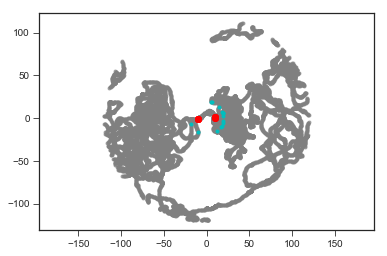

In [100]:
# Check if alignment is correct
plt.plot(xtrial,ytrial,'.',color='grey', alpha=0.6)
plt.plot(xtrial[ev>0],ytrial[ev>0],'ro')
plt.plot(xtrial[entries>0],ytrial[entries>0],'c.')
plt.axis('equal')
print(fly)

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


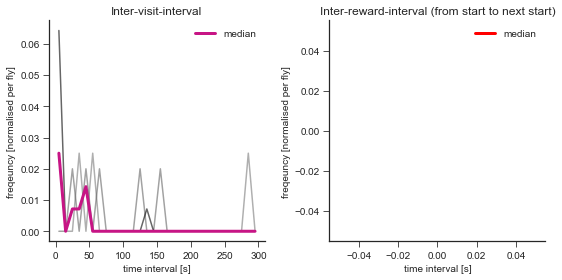

In [102]:
entrydistfig, axs = plt.subplots(1,2, figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

# generate colormap encoding total number of visits
cNorm  = colors.Normalize(vmin=-10, vmax=max(numEntries))
entryCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Greys')

# plot distribution
for fly in range(numFlies):
    axs[0].plot(binEds,flyEntryTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numEntries[fly]), alpha=0.6, label='')
    axs[1].plot(binEds,flyRewardStTimeDistr[fly,:], 
                    color=entryCMap.to_rgba(numRewards[fly]), alpha=0.6, label='')
axs[0].plot(binEds,np.nanmedian(flyEntryTimeDistr,axis=0), color='mediumvioletred', linewidth=3, label='median')
axs[0].set_title('Inter-visit-interval')

axs[1].plot(binEds,np.nanmedian(flyRewardStTimeDistr,axis=0), color='red', linewidth=3, label='median')
axs[1].set_title('Inter-reward-interval (from start to next start)')

for ax in axs:
    myAxisTheme(ax)
    ax.set_xlabel('time interval [s]')
    ax.set_ylabel('freqeuncy [normalised per fly]')
    ax.legend()
        
entrydistfig.tight_layout()

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalDistr_singleFly_rewardRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


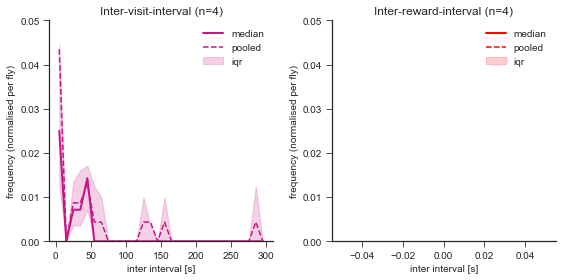

In [103]:
entrydistfig, axs = plt.subplots(1,2,figsize=(8,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

[qt25, qt50, qt75] = np.nanpercentile(flyEntryTimeDistr[:,:],[25,50,75],axis=0)
axs[0].plot(binEds,qt50, color='mediumvioletred', linewidth=2, label='median')
axs[0].fill_between(binEds,qt25, qt75, color='mediumvioletred', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(allInterEntryTimes, bins=numBins, range=binRange, density=True)
axs[0].plot(binEds,hist, color='mediumvioletred', linewidth=1.5, linestyle='dashed', label='pooled')

axs[0].set_title('Inter-visit-interval (n='+str(numFlies)+')')
interVisitIntervalDistr = [qt25,qt50,qt75,hist]

[qt25, qt50, qt75] = np.nanpercentile(flyRewardStTimeDistr[:,:],[25,50,75],axis=0)
axs[1].plot(binEds,qt50, color='red', linewidth=2, label='median')
axs[1].fill_between(binEds,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.2)

hist, bin_edges = np.histogram(allRewardTimes, bins=numBins, range=binRange, density=True)
axs[1].plot(binEds,hist, color='red', linewidth=1.5, linestyle='dashed', label='pooled')

axs[1].set_title('Inter-reward-interval (n='+str(numFlies)+')')
interRewardIntervalDistr = [qt25,qt50,qt75,hist]


for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_ylim(0,.05)
    ax.set_xlabel('inter interval [s]')
    ax.set_ylabel('frequency (normalised per fly)')

entrydistfig.tight_layout()

np.save(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interVisitInterval_percentile25-50-75_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interVisitIntervalDistr)
np.save(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interRewardInterval_percentile25-50-75_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag, interRewardIntervalDistr)

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalDistr_medianIQR_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

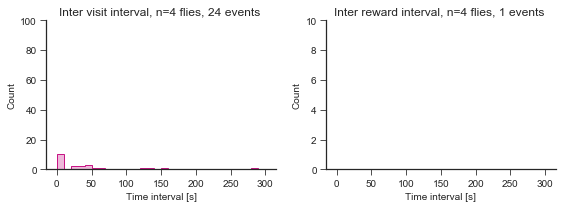

In [104]:
entrydistfig, axs = plt.subplots(1,2,figsize=(8,3))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2

labelTxt = ['visit', 'reward']
axs[0].hist(allInterEntryTimes, bins=numBins, range=binRange, color='mediumvioletred',histtype='step')
axs[0].hist(allInterEntryTimes, bins=numBins, range=binRange, color='mediumvioletred',histtype='stepfilled', alpha=0.3)
#hist, bin_edges = np.histogram(np.diff(allInterEntryTimes), bins=numBins, range=binRange, density=False)
#axs[0].plot(binEds,hist, color='mediumvioletred', linewidth=1.5, linestyle='solid', label='pooled')
axs[0].set_ylim(0,100)
axs[0].set_title('Inter {} interval, n={} flies, {} events '.format(labelTxt[0], numFlies, len(allInterEntryTimes)))

axs[1].hist(allRewardTimes, bins=numBins, range=binRange, color='red', histtype='step')
axs[1].hist(allRewardTimes, bins=numBins, range=binRange, color='red', histtype='stepfilled', alpha=0.3)
#hist, bin_edges = np.histogram(np.diff(allRewardTimes), bins=numBins, range=binRange, density=False)
#axs[1].plot(binEds,hist, color='red', linewidth=1.5, linestyle='solid', label='pooled')
axs[1].set_ylim(0,10)
axs[1].set_title('Inter {} interval, n={} flies, {} events '.format(labelTxt[1], numFlies, len(allRewardTimes)))

for i, ax in enumerate(axs):
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Time interval [s]')
    ax.set_ylabel('Count') #frequency (normalised per fly)

entrydistfig.tight_layout()

entrydistfig.savefig(analysisDir + 'interVisitInterval/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_interEventIntervalHist_pooled_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Generate combined plot across groups (need to run analysis for each group first)

In [51]:
summaryDir = sep.join(analysisDir.split(sep)[:-2])+sep
try:
    mkdir(summaryDir + 'summaryPlots/')
except:
    print('Plot directory already exists')

Plot directory already exists


#### Inter-visit-interval

In [63]:
expDataName = 'Gr64f-doubleGal4_x_10xChrimsonR_f_visLM_interVisitInterval_percentile25-50-75_visitRad10mm_n12.npy'
expDataCond = 'visible LM'
expIVIDistr = np.load(summaryDir+ 'analysis/interVisitInterval'+sep+expDataName)

contrDataName = 'Gr64f-doubleGal4_x_10xChrimsonR_f_noLM_interVisitInterval_percentile25-50-75_visitRad10mm_n12.npy'
contrDataCond = 'invisible LM'
contrIVIDistr = np.load(summaryDir+'analysis/interVisitInterval'+sep+contrDataName)

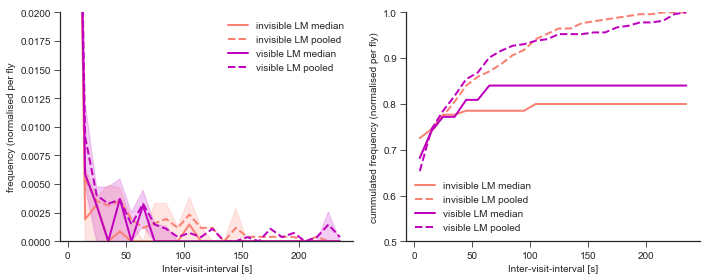

In [64]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2
#binEds = np.linspace(0,10,41)[1:]-(5./40)

axs[0].plot(binEds,contrIVIDistr[1], color='salmon', linewidth=2, label='{} median'.format(contrDataCond))
axs[0].fill_between(binEds,contrIVIDistr[0], contrIVIDistr[2], color='salmon', linewidth=1, alpha=0.2) #label='{} IQR'.format(contrDataCond)
axs[0].plot(binEds,contrIVIDistr[3], color='salmon', linewidth=2, linestyle='dashed', label='{} pooled'.format(contrDataCond))

axs[0].plot(binEds,expIVIDistr[1], color='m', linewidth=2, label='{} median'.format(expDataCond))
axs[0].fill_between(binEds,expIVIDistr[0], expIVIDistr[2], color='m', linewidth=1, alpha=0.2) #label='{} IQR'.format(expDataCond),
axs[0].plot(binEds,expIVIDistr[3], color='m', linewidth=2, linestyle='dashed', label='{} pooled'.format(expDataCond))

axs[1].plot(binEds,np.cumsum(contrIVIDistr[1]*np.diff(bin_edges)), color='salmon', linewidth=2, label='{} median'.format(contrDataCond))
axs[1].plot(binEds,np.cumsum(contrIVIDistr[3]*np.diff(bin_edges)), color='salmon', linewidth=2, linestyle='dashed', label='{} pooled'.format(contrDataCond))

axs[1].plot(binEds,np.cumsum(expIVIDistr[1]*np.diff(bin_edges)), color='m', linewidth=2, label='{} median'.format(expDataCond))
axs[1].plot(binEds,np.cumsum(expIVIDistr[3]*np.diff(bin_edges)), color='m', linewidth=2, linestyle='dashed', label='{} pooled'.format(expDataCond))

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Inter-visit-interval [s]')
axs[0].set_ylim(0,0.02)
axs[1].set_ylim(0.5,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')


fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+genotype+'_interVisitIntervalDistr_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

#### Inter-reward-interval

In [65]:
expDataNameR = 'Gr64f-doubleGal4_x_10xChrimsonR_f_visLM_interRewardInterval_percentile25-50-75_visitRad10mm_n12.npy'
expDataCond = 'visible LM'
expIVIDistrR = np.load(summaryDir+ 'analysis/interVisitInterval'+sep+expDataNameR)

contrDataNameR = 'Gr64f-doubleGal4_x_10xChrimsonR_f_noLM_interRewardInterval_percentile25-50-75_visitRad10mm_n12.npy'
contrDataCond = 'invisible LM'
contrIVIDistrR = np.load(summaryDir+'analysis/interVisitInterval'+sep+contrDataNameR)

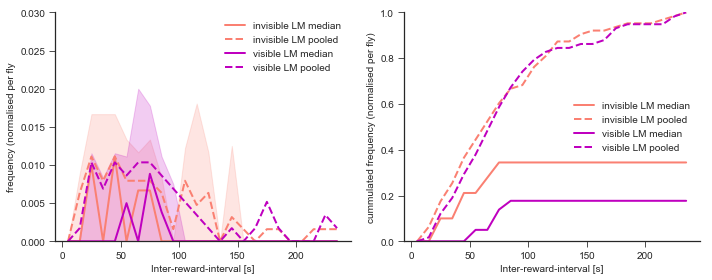

In [66]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2
#binEds = np.linspace(0,10,41)[1:]-(5./40)

axs[0].plot(binEds,contrIVIDistrR[1], color='salmon', linewidth=2, label='{} median'.format(contrDataCond))
axs[0].fill_between(binEds,contrIVIDistrR[0], contrIVIDistrR[2], color='salmon', linewidth=1, alpha=0.2)
axs[0].plot(binEds,contrIVIDistrR[3], color='salmon', linewidth=2, linestyle='dashed', label='{} pooled'.format(contrDataCond))

axs[0].plot(binEds,expIVIDistrR[1], color='m', linewidth=2, label='{} median'.format(expDataCond))
axs[0].fill_between(binEds,expIVIDistrR[0], expIVIDistrR[2], color='m', linewidth=1, alpha=0.2)
axs[0].plot(binEds,expIVIDistrR[3], color='m', linewidth=2, linestyle='dashed', label='{} pooled'.format(expDataCond))

axs[1].plot(binEds,np.cumsum(contrIVIDistrR[1]*np.diff(bin_edges)), color='salmon', linewidth=2, label='{} median'.format(contrDataCond))
axs[1].plot(binEds,np.cumsum(contrIVIDistrR[3]*np.diff(bin_edges)), color='salmon', linewidth=2, linestyle='dashed', label='{} pooled'.format(contrDataCond))

axs[1].plot(binEds,np.cumsum(expIVIDistrR[1]*np.diff(bin_edges)), color='m', linewidth=2, label='{} median'.format(expDataCond))
axs[1].plot(binEds,np.cumsum(expIVIDistrR[3]*np.diff(bin_edges)), color='m', linewidth=2, linestyle='dashed', label='{} pooled'.format(expDataCond))

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Inter-reward-interval [s]')
axs[0].set_ylim(0,0.03)
axs[1].set_ylim(0,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')


fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+genotype+'_interRewardIntervalDistr_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

#### Both

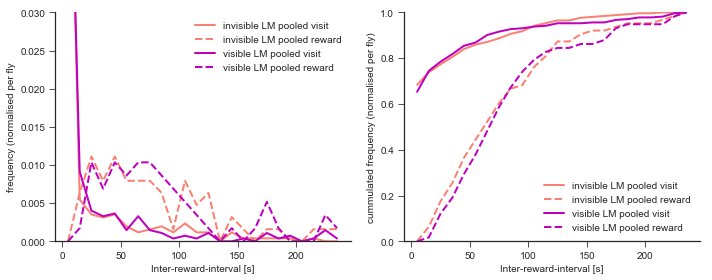

In [67]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2
#binEds = np.linspace(0,10,41)[1:]-(5./40)

axs[0].plot(binEds,contrIVIDistr[3], color='salmon', linewidth=2, linestyle='solid', label='{} pooled visit'.format(contrDataCond))
axs[0].plot(binEds,contrIVIDistrR[3], color='salmon', linewidth=2, linestyle='dashed', label='{} pooled reward'.format(contrDataCond))

axs[0].plot(binEds,expIVIDistr[3], color='m', linewidth=2, linestyle='solid', label='{} pooled visit'.format(expDataCond))
axs[0].plot(binEds,expIVIDistrR[3], color='m', linewidth=2, linestyle='dashed', label='{} pooled reward'.format(expDataCond))

axs[1].plot(binEds,np.cumsum(contrIVIDistr[3]*np.diff(bin_edges)), color='salmon', linewidth=2, linestyle='solid', label='{} pooled visit'.format(contrDataCond))
axs[1].plot(binEds,np.cumsum(contrIVIDistrR[3]*np.diff(bin_edges)), color='salmon', linewidth=2, linestyle='dashed', label='{} pooled reward'.format(contrDataCond))

axs[1].plot(binEds,np.cumsum(expIVIDistr[3]*np.diff(bin_edges)), color='m', linewidth=2, linestyle='solid', label='{} pooled visit'.format(expDataCond))
axs[1].plot(binEds,np.cumsum(expIVIDistrR[3]*np.diff(bin_edges)), color='m', linewidth=2, linestyle='dashed', label='{} pooled reward'.format(expDataCond))

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Inter-reward-interval [s]')
axs[0].set_ylim(0,0.03)
axs[1].set_ylim(0,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')


fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+genotype+'_interEventIntervalDistr_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

## Path shape *after* reinforcement
### Trigger on reinforcement and plot *walking velocities* for following x seconds (or until next reinforcement is delivered)

In [105]:
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')

Plot directory already exists


In [106]:
tmax = 15
tmin = -3
window = int(fps*tmax)
prewindow = int(fps*-tmin)

#fig, ax = plt.subplots(1,1, figsize=(10,7))

triggVT = np.nan*np.ones((numFlies,window+prewindow))
triggVR = np.nan*np.ones((numFlies,window+prewindow))

for fly in range(numFlies):
    querystring = ' (flyID == "'+flyIDs[fly]+'")'
    vt = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
    vr = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()
    
    ev[ev>=evLevel] = 100
    ev[ev<evLevel] = 0
    ev = ev/100

    evEnd = np.where(np.diff(ev)<0)[0]
    evSt = np.where(np.diff(ev)>0)[0]

    flyVT = []
    flyVR = []
    for i, es in enumerate(evEnd):
        pathSt = es-prewindow
        if i+1<len(evSt):
            pathEd = min(es+window, evSt[i+1])
        else:
            pathEd = min(es+window, len(time)-1)
        
        vti = vt[pathSt:pathEd]
        vri = abs(vr[pathSt:pathEd])
        timeax = np.linspace(tmin,time[pathEd]-time[es], pathEd-pathSt)
        
        if vti.size == 0:
            continue

        flyVT.append(vti)
        flyVR.append(vri)

    for k in range(len(triggVT[0])):
        val = []
        for sl in flyVT:
            if k < len(sl):
                val.append(sl[k])
        triggVT[fly,k] = np.nanmean(np.asarray(val))
        
        val = []
        for sl in flyVR:
            if k < len(sl):
                val.append(sl[k])
        triggVR[fly,k] = np.nanmean(np.asarray(val))

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


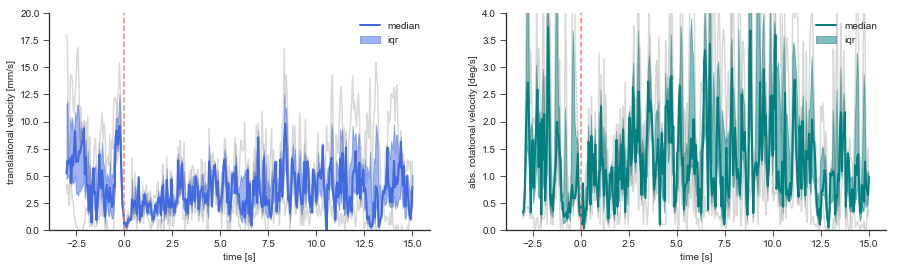

In [107]:
fig, axs = plt.subplots(1,2,figsize=(15,4))

timeax = np.linspace(tmin,tmax, window+prewindow)
for fly in range(numFlies):
    axs[0].plot(timeax,triggVT[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVT,[25,50,75],axis=0)
axs[0].plot(timeax,qt50, color='royalblue', linewidth=2, label='median')
axs[0].fill_between(timeax,qt25, qt75, color='royalblue', linewidth=1, label='iqr', alpha=0.5)

for fly in range(numFlies):
    axs[1].plot(timeax,triggVR[fly,:], color='grey',alpha=0.3, label='')
    
[qt25, qt50, qt75] = np.nanpercentile(triggVR,[25,50,75],axis=0)
axs[1].plot(timeax,qt50, color='teal', linewidth=2, label='median')
axs[1].fill_between(timeax,qt25, qt75, color='teal', linewidth=1, label='iqr', alpha=0.5)

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.axvline(0,0,1,color='salmon', linestyle='dashed', linewidth=1.5)
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,4)
axs[0].set_ylabel('translational velocity [mm/s]')
axs[1].set_ylabel('abs. rotational velocity [deg/s]')
    
fig.savefig(analysisDir + 'reinforcementEffect/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
    +'_triggeredVelo_medianIQRAcrossFlies_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Trigger on reinforcement and plot *path* for following x seconds (or until next reinforcement is delivered)

### Trigger on reinforcement and plot *absolute distance moved* for following x seconds (or until next reinforcement is delivered)

In [108]:
try:
    mkdir(analysisDir + 'distanceMoved/')
except:
    print('Plot directory already exists')

Plot directory already exists


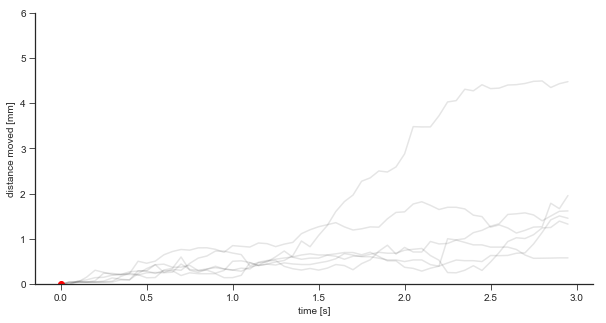

In [122]:
window = int(fps*3)

fig, ax = plt.subplots(1,1, figsize=(10,5))

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(ev>evLevel)[0]
    
    for i, es in enumerate(evStart):
        pathSt = es
        if i+1<len(evStart):
            pathEd = min(es+window, evStart[i+1])
        else:
            pathEd = min(es+window, len(ev))
        pathX = xtrial[pathSt:pathEd]-xtrial[pathSt]
        pathY = ytrial[pathSt:pathEd]-ytrial[pathSt]
        dist = np.hypot(pathX,pathY)
        
        if pathY.size == 0:
            print('no path, path st {}, path end {}'.format(pathSt, pathEd))
            continue

        ax.plot(time[pathSt:pathEd]-time[pathSt],dist,'k',alpha=0.1)

        if i+1<len(evStart):
            if es+window > evStart[i+1]:
                ax.plot(time[pathEd-1]-time[pathSt],dist[-1],'r.',alpha=0.5)


ax.plot(0,0,'ro')
ax.set_ylim(0,6)
ax.set_xlabel('time [s]')
ax.set_ylabel('distance moved [mm]')
myAxisTheme(ax)

fig.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_distAfterReward_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

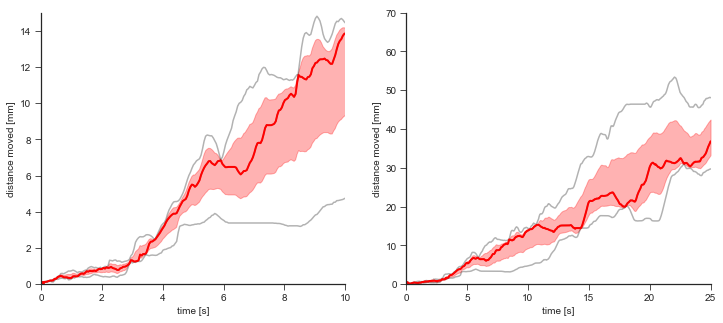

In [123]:
tmax = [10, 25]
ymax = [15, 70]
fig, ax = plt.subplots(1,2, figsize=(12,5))
window = int(fps*tmax[1])
timeax = np.linspace(0,tmax[1], window)

distAll = np.nan*np.ones((numFlies, window))

for fly in range(numFlies):
    querystring = '(flyID == "'+flyIDs[fly]+'")'
    xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
    ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
    ev = FOAllFlies_df.query(querystring)['rEvents'].values.squeeze()
    time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

    evStart = np.where(ev>evLevel)[0]

    dist = np.nan*np.ones((len(evStart), window))
    for k, es in enumerate(evStart):
        if (es + window) > len(xtrial):
            continue
        pathX = xtrial[es:es+window]-xtrial[es]
        pathY = ytrial[es:es+window]-ytrial[es]
        dist[k,:] = np.hypot(pathX,pathY)

    for i in range(2):    
        ax[i].plot(timeax,np.nanmedian(dist, axis=0),'k', alpha=0.3)

    distAll[fly,:] = np.nanmedian(dist, axis=0)

for i in range(2):
    [qt25, qt50, qt75] = np.nanpercentile(distAll,[25,50,75],axis=0)

    ax[i].plot(timeax,qt50, color='red', linewidth=2, label='median')
    ax[i].fill_between(timeax,qt25, qt75, color='red', linewidth=1, label='iqr', alpha=0.3)

    ax[i].plot(0,0,'ro')
    ax[i].set_xlim(0,tmax[i])
    ax[i].set_ylim(0,ymax[i])
    ax[i].set_xlabel('time [s]')
    ax[i].set_ylabel('distance moved [mm]')
    myAxisTheme(ax[i])

fig.savefig(analysisDir + 'distanceMoved/'+genotype +'_'+flyIDs[0][0] +'_'+ protocol
           +'_distAfterRewardMedianFly_'+str(int(window/fps))+'s_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Quantify "curvyness of path"
### Turtosity of path in sliding window

### Check if some flies had a strong bias in their rotational velocity

In [223]:
rotbias = np.nan*np.ones((numFlies, len(trialName)))
rotamount = np.nan*np.ones((numFlies, len(trialName)))

for fly in range(numFlies):
    for i, trial in enumerate(trialName):
        querystring = '(flyID =="' + flyIDs[fly] +  '") & (moving > 0)'
        perFlyvR = FOAllFlies_df.query(querystring)['rotVelo'].values.squeeze()

        if len(perFlyvR) == 0: continue
        
        rotbias[fly,i] = abs(sum(perFlyvR<0) - sum(perFlyvR>0)) / float(len(perFlyvR))
        rotamount[fly,i] = np.mean(abs(perFlyvR))

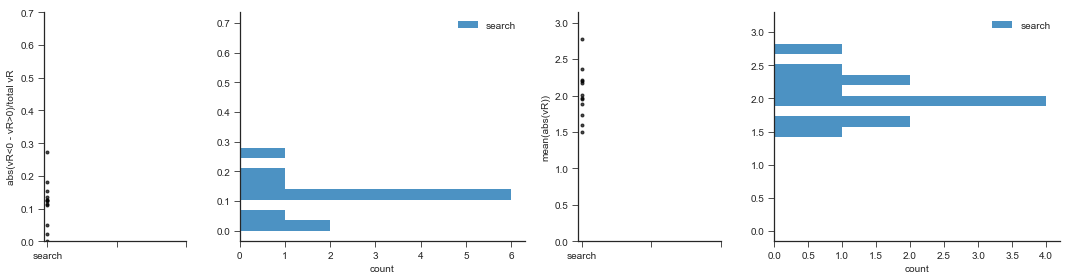

In [225]:
rotBiasfig, axs = plt.subplots(1,4,figsize=(15,4), gridspec_kw={'width_ratios':[1,2,1,2]})

axs[0].plot(rotbias.T, alpha=0.7, color='grey')
axs[0].plot(rotbias.T, '.', alpha=0.7,color='k')
axs[0].set_xticks([0,1,2])
axs[0].set_xticklabels(trialName)
axs[0].set_ylim(0, 0.7)
axs[0].set_ylabel('abs(vR<0 - vR>0)/total vR')

axs[1].hist(rotbias[:,:], range=(0,0.7), bins=20, cumulative=False, histtype='bar',
            align='mid',  orientation='horizontal', alpha=0.8)
axs[1].legend(trialName)
axs[1].set_xlabel('count')

axs[2].plot(rotamount.T, alpha=0.7,color='grey')
axs[2].plot(rotamount.T, '.', alpha=0.7,color='k')
axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels(trialName)
axs[2].set_ylim(0, np.pi)
axs[2].set_ylabel('mean(abs(vR))')

axs[3].hist(rotamount[:,:], range=(0,np.pi), bins=20, cumulative=False, histtype='bar',
            align='mid', orientation='horizontal',  alpha=0.8)
axs[3].legend(trialName)
axs[3].set_xlabel('count')

for ax in axs:
    myAxisTheme(ax)
rotBiasfig.tight_layout()

#rotBiasfig.savefig(analysisDir + sep + 'velocityTraces' + sep +genotype +'_'+flyIDs[0][0] +'_'+ protocol+
#                   '_walingVelocities_rotationalBias_n'+str(numFlies)+selectionTag+'.pdf', format = 'pdf')

In [234]:
# Which flies had an excessive rotational bias throughout the experiment?
maxRotBias = 0.25

highRotBias = np.where(np.sum(rotbias>maxRotBias, axis=1)==3)[0]

print('Out of {} measured flies, {} had a rotational bias above {} in all three trials.\n').format(numFlies,
     len(highRotBias), maxRotBias)
print ('Those flies were: {}'.format([flyIDs[i] for i in highRotBias]))
print ('With indices {}'.format( highRotBias))

Out of 22 measured flies, 0 had a rotational bias above 0.25 in all three trials.

Those flies were: []
With indices []
